# Vertical stream function conservation

author, Wenrui Jiang 06/06/2022

This notebook is also an idealized test for 2D flow like [the horizontal case](./hor_stream). However, it has a slightly different flavor.

- This notebook looks at the vertical direction rather than the horizontal one.
- We are going to simulate the particles backward in time.
- The "wall" behavior of the particles are explored.

In [1]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import cm, colors

import seaduck as sd

mpl.rcParams["figure.dpi"] = 300

warnings.filterwarnings("ignore")

## Loading data

As always, we need to load the data. For simplicity and to demonstrate the capacity of particles sliding on the wall, I am going to use the stream function of an $f$-plane gyre. You can think of this example as a zonal overturning cell in a meridional channel.

In [2]:
def streamfunction(x, z):
    tempz = -z / 500 - 1
    return np.cos(np.pi * x / 2) * np.cos(np.pi * tempz / 2)

In [3]:
N = 100
M = 50
x = np.linspace(-1, 1, N + 1)
y = np.linspace(-0.1, 0.1, 2)
zl = np.linspace(0, -1000, M)
zp1 = np.append(zl, -1001)
xg, yg = np.meshgrid(x, y)
xv = 0.5 * (xg[:, 1:] + xg[:, :-1])
yv = 0.5 * (yg[:, 1:] + yg[:, :-1])
xu = 0.5 * (xg[1:] + xg[:-1])
yu = 0.5 * (yg[1:] + yg[:-1])

xc = 0.5 * (xv[1:] + xv[:-1])
yc = 0.5 * (yv[1:] + yv[:-1])

tempx, tempz = np.meshgrid(x, zl)
strmf = streamfunction(tempx, tempz).reshape(len(zl), 1, -1)
z = 0.5 * (zp1[1:] + zp1[:-1])
zl = zp1[:-1]
drf = np.abs(np.diff(zp1))

In [4]:
u = np.zeros((M, 1, N + 1), float)
u[:-1] = np.diff(strmf, axis=0)
w = np.diff(strmf, axis=-1)
v = np.zeros((M, 2, N), float)

In [5]:
stream = np.zeros((M, 2, N + 1))
stream[:] = strmf

In [6]:
ds = xr.Dataset(
    coords=dict(
        XC=(["Y", "X"], xc),
        YC=(["Y", "X"], yc),
        XG=(["Yp1", "Xp1"], xg),
        YG=(["Yp1", "Xp1"], yg),
        Zl=(["Zl"], zl),
        Z=(["Z"], z),
        drF=(["Z"], drf),
        rA=(["Y", "X"], np.ones_like(xc, float)),
    ),
    data_vars=dict(
        UVELMASS=(["Z", "Y", "Xp1"], u),
        VVELMASS=(["Z", "Yp1", "X"], v),
        WVELMASS=(["Zl", "Y", "X"], w),
        streamfunc=(["Zl", "Yp1", "Xp1"], stream),
    ),
)
ds

<xarray.Dataset>
Dimensions:     (Z: 50, Y: 1, Xp1: 101, Yp1: 2, X: 100, Zl: 50)
Coordinates:
    XC          (Y, X) float64 -0.99 -0.97 -0.95 -0.93 ... 0.93 0.95 0.97 0.99
    YC          (Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    XG          (Yp1, Xp1) float64 -1.0 -0.98 -0.96 -0.94 ... 0.94 0.96 0.98 1.0
    YG          (Yp1, Xp1) float64 -0.1 -0.1 -0.1 -0.1 -0.1 ... 0.1 0.1 0.1 0.1
  * Zl          (Zl) float64 0.0 -20.41 -40.82 -61.22 ... -959.2 -979.6 -1e+03
  * Z           (Z) float64 -10.2 -30.61 -51.02 -71.43 ... -969.4 -989.8 -1e+03
    drF         (Z) float64 20.41 20.41 20.41 20.41 ... 20.41 20.41 20.41 1.0
    rA          (Y, X) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Dimensions without coordinates: Y, Xp1, Yp1, X
Data variables:
    UVELMASS    (Z, Y, Xp1) float64 3.923e-18 0.002012 0.004023 ... 0.0 0.0 0.0
    VVELMASS    (Z, Yp1, X) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    WVELMASS    (Zl, Y, X) float64 1.923e-18 1.921e-18 ... -1.921e-18 -1.923e-18
    streamfunc  (Zl, Yp1, Xp1) float64 3.749e-33 1.923e-18 ... 3.749e-33

## Prepare the test

First, we convert the `xarray.Dataset` to `seaduck.OceData`

In [7]:
tub = sd.OceData(ds)

Now we define the initial condition of particles such that some particles are right **on the wall/at the corner**.

In [8]:
n = 30
m = 30
x = np.linspace(-1, 1, n + 1)
z = np.linspace(-0.1, -1000, m + 1)
x, z = np.meshgrid(x, z)
x = x.ravel()
z = z.ravel()

Let's store which ones are on the wall and which ones are at the corner for plotting purposes.

In [9]:
on_x_wall = np.abs(x) == 1
on_z_wall = np.logical_or(z == z.min(), z == z.max())
coloring = (0.2 + np.logical_or(on_x_wall, on_z_wall)) / 1.2
corner = np.logical_and(on_x_wall, on_z_wall)

## Run the test and plot

Finally, we can run the simulation, and plot the trajectories.

In [10]:
pt = sd.Particle(
    x=x, y=np.zeros_like(x), z=z, t=np.zeros_like(x), data=tub, transport=True
)

Again, we will look at how much the stream function changed before and after the simulation.

In [11]:
kkk = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

gknw = sd.KnW(kkk, vkernel="linear", tkernel="nearest")

In [12]:
before = pt.interpolate("streamfunc", gknw)

In [13]:
steps = 40
stops, ps = pt.to_list_of_time(
    normal_stops=np.linspace(0, -2 * steps * N, steps), update_stops=[]
)

In [14]:
after = pt.interpolate("streamfunc", gknw)

Like promised, the difference is indeed very small.

In [15]:
is_it_close = np.allclose(after, before, atol=1e-7)
max_difference = np.max(np.abs(after - before))
print(f"Is the stream function is conserved? {is_it_close}")
print(f"The maximum difference is {max_difference }")

Is the stream function is conserved? True
The maximum difference is 6.844423466878524e-08


In [16]:
lons = []
deps = []
for ppp in ps:
    lons.append(ppp.lon)
    deps.append(ppp.dep)
lons = np.array(lons)
deps = np.array(deps)

In [17]:
norm = colors.Normalize(vmin=0.0, vmax=1.0, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.binary)

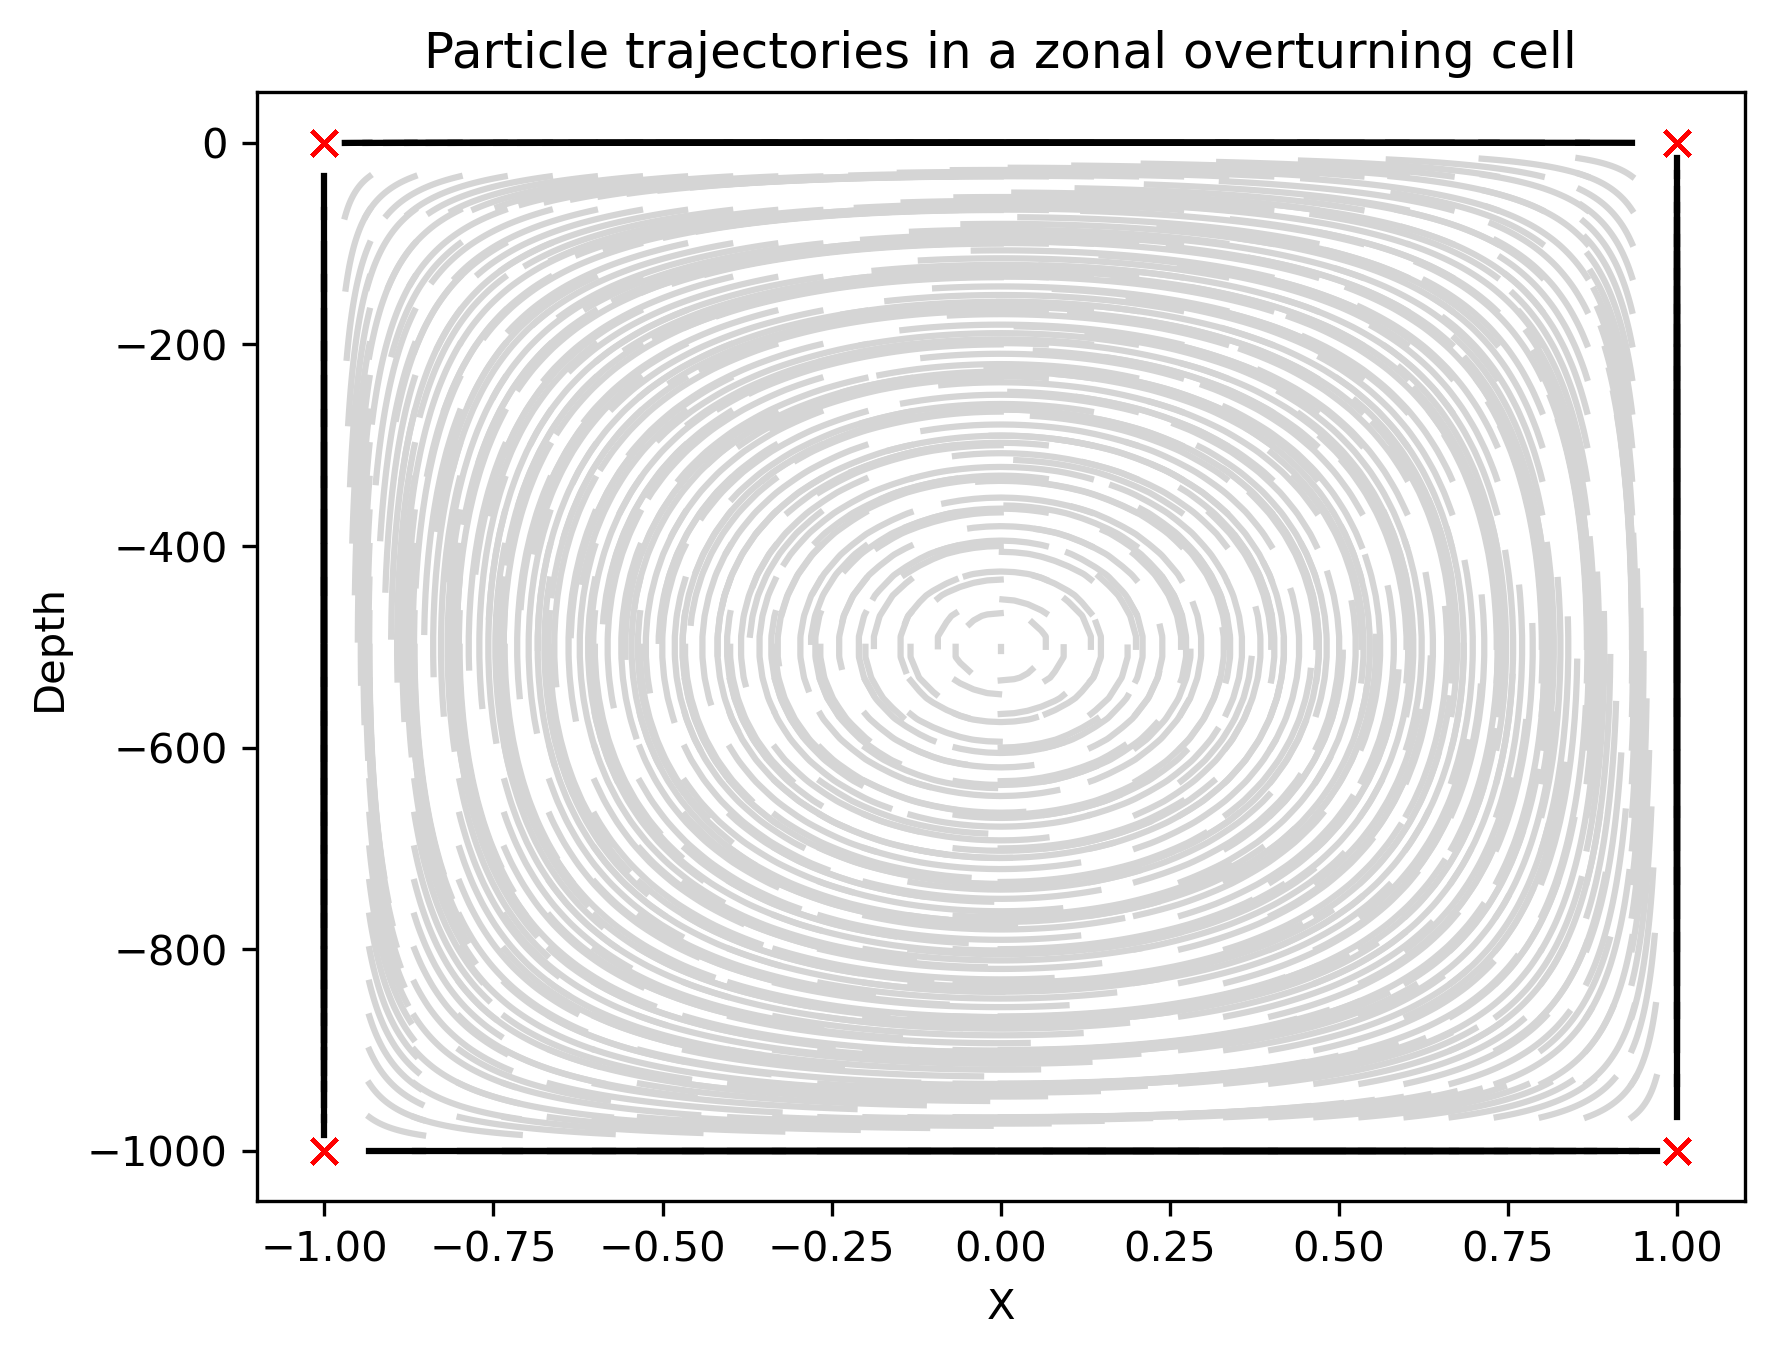

In [18]:
for i in range(len(x)):
    if corner[i]:
        plt.plot(lons.T[i], deps.T[i], "x-", c="r")
    plt.plot(lons.T[i], deps.T[i], c=mapper.to_rgba(coloring[i]))
plt.ylabel("Depth")
plt.xlabel("X")
plt.title("Particle trajectories in a zonal overturning cell")
plt.show()

**Fig.1** Particle trajectories in zonal overturning cell. Grey and black lines represent the trajectories of interior and wall attached particles, respectively. The red crosses show the trajectories of corner points.

## Remarks

Hopefully, this has already convinced you that the paticles are conserving streamfunction in the vertical.

The non-penetrating condition means that particles on the wall will not detach in any finite time. Likewise, particles at the corners will never leave.

At the center, the point with maximum stream function has nowhere to go, so it stays there forever.